In [1]:
from PIL import Image, ImageDraw
import numpy
import math
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
import cv2

In [26]:
# sample.png is the name of the image 
# file and assuming that it is uploaded 
# in the current directory or we need 
# to give the path 
image_path = "skewed_paragraph.png"
image = Image.open(image_path) 
  
# summarize some details about the image 
print(image.format) 
x_max, y_max = image.size
print(image.size)
print(image.mode)

PNG
(1596, 366)
RGBA


Threshold: 254


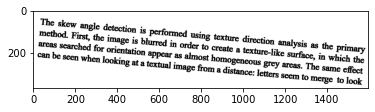

In [27]:
im = cv2.imread(image_path,0)
flat = numpy.reshape(im,(im.shape[0]*im.shape[1]))
[hist, _] = numpy.histogram(flat, bins=256, range=(0, 255))
hist = 1.0*hist/numpy.sum(hist)
val_max = -999
thr = -1
for t in range(1,255):
    # Non-efficient implementation
    q1 = numpy.sum(hist[:t])
    q2 = numpy.sum(hist[t:])
    m1 = numpy.sum(numpy.array([i for i in range(t)])*hist[:t])/(q1+1)
    m2 = numpy.sum(numpy.array([i for i in range(t,256)])*hist[t:])/(q2+1)
    val = q1*(1-q1)*numpy.power(m1-m2,2)
    if val_max < val:
        val_max = val
        thr = t
        
print("Threshold: {}".format(thr))
plt.imshow(im > thr, cmap = 'gray')
plt.show()

fn = lambda x : 255 if x > thr else 0
r = image.convert('L').point(fn, mode='1')
r.show()

In [28]:
numpydata = numpy.asarray(r)
im = Image.fromarray(numpydata)
im.show()

In [29]:
max_r = math.floor(numpy.sqrt((x_max/2)**2 + (y_max/2)**2))
max_theta = math.floor(math.pi*1000)
x_o = math.floor(x_max/2)
y_o = math.floor(y_max/2)
accumulator = numpy.zeros((2*max_r+1,max_theta))
points = []
for index, value in numpy.ndenumerate(numpydata):
    if not value:
        y,x = index
        y = (y_max-y) - y_o
        x = x - x_o
        for theta in range(0,max_theta):
            r = round(x*math.cos(theta/1000) + y*math.sin(theta/1000))
            r += max_r
            accumulator[r,theta] += 1
        
    

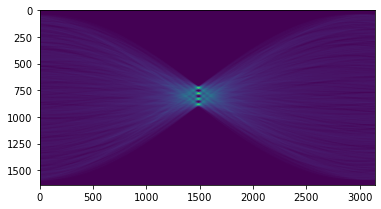

In [30]:
plt.imshow(accumulator)

In [ ]:
def initialize(points,k):
    ##initialize k centroids:
    centroids = []
    for i in range(k):
        centroid = []
        for dim_length in points.shape:
            centroid.append(random.randint(0,dim_length))
        centroids.append(tuple(centroid))
    return numpy.array(centroids)

def closest_centroid(grid, centroids):
    distances = numpy.sqrt(((grid - centroids[:,:,numpy.newaxis,numpy.newaxis])**2).sum(axis = 1))
    array2D = numpy.reshape(distances,(distances.shape[0],distances.shape[1]*distances.shape[2])) 
    mins = numpy.argmin(array2D, axis=0)
    #print(mins.shape)
    return numpy.reshape(mins,(distances.shape[1:]))

def k_means(points,k,iterations):
    centroids = initialize(points,k)
    grid = numpy.indices(points.shape)
    for i in range(iterations):
        closest_centroids = closest_centroid(grid,centroids)
        print("iteration: " + str(i+1))
        centroids = numpy.zeros((k,len(points.shape)))
        num_for_each = numpy.zeros((k,1))
        for index,value in numpy.ndenumerate(closest_centroids):
            #print(value)
            number = points[index]
            centroids[value] += numpy.array(index)*number
            num_for_each[value,0] += number
        centroids = centroids/num_for_each   
        print(centroids)
    return centroids
    
centroids = k_means(accumulator,2,20)
print(centroids)

1160
Threshold: 27


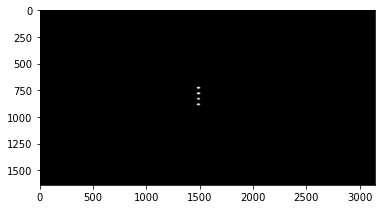

In [33]:
accum_flat = numpy.reshape(accumulator,(accumulator.shape[0]*accumulator.shape[1]))
max_number = int(numpy.max(accum_flat))
print(max_number)
[hist, _] = numpy.histogram(accum_flat, bins=max_number, range=(0, max_number-1))
hist = 1.0*hist/numpy.sum(hist)
val_max = -999
thr = -1
for t in range(1,max_number-1):
    # Non-efficient implementation
    q1 = numpy.sum(hist[:t])
    q2 = numpy.sum(hist[t:])
    m1 = numpy.sum(numpy.array([i for i in range(t)])*hist[:t])/(q1+1)
    m2 = numpy.sum(numpy.array([i for i in range(t,max_number)])*hist[t:])/(q2+1)
    val = q1*(1-q1)*numpy.power(m1-m2,2)
    if val_max < val:
        val_max = val
        thr = t
        
print("Threshold: {}".format(thr))

plt.imshow(accumulator > thr**2, cmap = 'gray')
plt.show()


In [35]:
to_cluster = []
for index,value in numpy.ndenumerate(accumulator):
    if value >= thr**2:
        for i in range(int(value)):
            to_cluster.append(index)
array=numpy.array(to_cluster)
kmeans = KMeans(n_clusters=4, random_state=0).fit(array)
kmeans.cluster_centers_

    

array([[ 830.03681607, 1485.88808603],
       [ 726.76700044, 1486.13420889],
       [ 881.99212155, 1485.46810486],
       [ 778.92491125, 1486.33649219]])

830.0368160665255 1485.888086033334
726.7670004386042 1486.1342088894787
881.9921215533349 1485.4681048593275
778.9249112464436 1486.33649219135


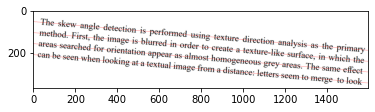

In [36]:
image = Image.open(image_path) 
img1 = ImageDraw.Draw(image)  
for i in range(kmeans.cluster_centers_.shape[0]):
    r,theta = kmeans.cluster_centers_[i]
    print(r,theta)
    r-=max_r
    theta = theta/1000
    #print(r,theta)
    x = r*math.cos(theta)
    y = r*math.sin(theta)
    m = y/x
    recip_opp_m = -1/m
    x_final = x + x_o
    y_final = y_max-(y+y_o)

    end_x = 1000 + x_final
    end_y = -1000*recip_opp_m + y_final
    begin_x = -1000 + x_final
    begin_y = 1000*recip_opp_m + y_final 
    shape = [(begin_x,begin_y), (end_x, end_y)]
    img1.line(shape, fill="red", width = 1) 
plt.imshow(image)
plt.show()

In [ ]:
saved_accumulator=accumulator
